## Test PyTorch version

Reference is found here: http://www.realworldnlpbook.com/blog/training-sentiment-analyzer-using-allennlp.html

In [249]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [250]:
from typing import Dict, Any
from pathlib import Path
import sys
import os
sys.path.append(os.path.join(os.getcwd(),".."))

import numpy as np
import torch
import torch.optim as optim
from allennlp.data.dataset_readers.stanford_sentiment_tree_bank import \
    StanfordSentimentTreeBankDatasetReader
from allennlp.data.iterators import BucketIterator
from allennlp.data.vocabulary import Vocabulary
from allennlp.models import Model
from allennlp.modules.seq2vec_encoders import Seq2VecEncoder, PytorchSeq2VecWrapper
from allennlp.modules.text_field_embedders import TextFieldEmbedder, BasicTextFieldEmbedder
from allennlp.modules.token_embedders import Embedding, ElmoTokenEmbedder
from allennlp.data.token_indexers.elmo_indexer import ELMoTokenCharactersIndexer
from allennlp.nn.util import get_text_field_mask
from allennlp.training.metrics import CategoricalAccuracy, F1Measure
from allennlp.training.trainer import Trainer

from haberrspd.predictors import SentenceClassifierPredictor # copied to main directory

### Build bespoke dataset

In [251]:
DATA_ROOT = Path("../data") / "MJFF"

In [252]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)

    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
config = Config(
    testing=True,
    seed=1,
    batch_size=32,
    lr=1e-4,
    epochs=20,
    hidden_sz=128,
    max_seq_len=100,  # necessary to limit memory usage
    max_vocab_size=100000,
)

In [254]:
from allennlp.data.tokenizers.word_splitter import SpacyWordSplitter
from allennlp.data.token_indexers import SingleIdTokenIndexer
from haberrspd.pdnet_elmo import MJFFdatasetReader

# The token indexer is responsible for mapping tokens to integers
token_indexer = ELMoTokenCharactersIndexer()

# Specify the tokeniser
def tokenizer(x: str):
    return [w.text for w in SpacyWordSplitter(language='en_core_web_sm', pos_tags=False).split_words(x)[:config.max_seq_len]]

# Reader instance to get the MJFF data
reader = MJFFdatasetReader(tokenizer=tokenizer,
                           token_indexers={"tokens": token_indexer},
                           max_seq_len=config.max_seq_len,
                           testing=config.testing)

# Load the processed MJFF dataset members (train and test)
# TODO: ensure that we are shuffling the rows of inputs before we do the actual classification
train_ds, validate_ds, test_ds = (reader.read(DATA_ROOT / filename) for filename in ["train_MJFF_English.csv",
                                                                        "validate_MJFF_English.csv",
                                                                        "test_MJFF_English.csv"])
# We don't need to build the vocab: all that is handled by the token indexer
vocab = Vocabulary()

# The iterator is responsible for batching the data and preparing it for input into the model. 
# We'll use the BucketIterator that batches text sequences of similar lengths together.
iterator = BucketIterator(batch_size=config.batch_size, sorting_keys=[("tokens", "num_tokens")])
iterator.index_with(vocab)



0it [00:00, ?it/s]

214it [00:00, 2139.86it/s]

436it [00:00, 2161.75it/s]

655it [00:00, 2165.25it/s]

873it [00:00, 2164.28it/s]

941it [00:00, 2160.68it/s]

0it [00:00, ?it/s]

118it [00:00, 2055.72it/s]

0it [00:00, ?it/s]

118it [00:00, 2081.12it/s]

---

## Model

In [255]:
# Model in AllenNLP represents a model that is trained.
class BasicSentenceClassifier(Model):
    def __init__(self,
                 word_embeddings: TextFieldEmbedder,
                 encoder: Seq2VecEncoder,
                 output_size: int) -> None:
        super().__init__(vocab)
        # We need the embeddings to convert word IDs to their vector representations
        self.word_embeddings = word_embeddings
        # Seq2VecEncoder is a neural network abstraction that takes a sequence of something
        # (usually a sequence of embedded word vectors), processes it, and returns it as a single
        # vector. Oftentimes, this is an RNN-based architecture (e.g., LSTM or GRU), but
        # AllenNLP also supports CNNs and other simple architectures (for example,
        # just averaging over the input vectors).
        self.encoder = encoder
        # After converting a sequence of vectors to a single vector, we feed it into
        # a fully-connected linear layer to reduce the dimension to the total number of labels.
        self.projection = torch.nn.Linear(in_features=encoder.get_output_dim(),
                                          out_features=output_size)
        # We use the cross-entropy loss because this is a classification task.
        # Note that PyTorch's CrossEntropyLoss combines softmax and log likelihood loss,
        # which makes it unnecessary to add a separate softmax layer.
        
        #self.loss_function = torch.nn.CrossEntropyLoss()
        self.loss_function = torch.nn.BCEWithLogitsLoss()

    # Instances are fed to forward after batching.
    # Fields are passed through arguments with the same name.
    def forward(self,
                tokens: Dict[str, torch.Tensor],
                Patient_ID: Any,
                Diagnosis: torch.Tensor) -> torch.Tensor:
        # In deep NLP, when sequences of tensors in different lengths are batched together,
        # shorter sequences get padded with zeros to make them of equal length.
        # Masking is the process to ignore extra zeros added by padding
        mask = get_text_field_mask(tokens)
        # Forward pass
        embeddings = self.word_embeddings(tokens)
        encoder_out = self.encoder(embeddings, mask)
        class_logits = self.projection(encoder_out).view(-1)

        # In AllenNLP, the output of forward() is a dictionary.
        # Your output dictionary must contain a "loss" key for your model to be trained.
        output = {"class_logit": class_logits}
        output["loss"] = self.loss_function(class_logits, Diagnosis.float())

        return output

### Small pre-trained model

In [103]:
# Use the 'Small' pre-trained model
options_file = ('https://s3-us-west-2.amazonaws.com/allennlp/models/elmo'
                '/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_options.json')
weight_file = ('https://s3-us-west-2.amazonaws.com/allennlp/models/elmo'
               '/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5')
elmo_embedder = ElmoTokenEmbedder(options_file, weight_file)
# BasicTextFieldEmbedder takes a dict - we need an embedding just for tokens,
# not for labels, which are used as-is as the "answer" of the sentence classification
word_embeddings = BasicTextFieldEmbedder({"tokens": elmo_embedder})

### Medium pre-trained model

In [256]:
options_file = ('https://s3-us-west-2.amazonaws.com/allennlp/models/elmo'
                '/2x2048_256_2048cnn_1xhighway/elmo_2x2048_256_2048cnn_1xhighway_options.json')
weight_file = ('https://s3-us-west-2.amazonaws.com/allennlp/models/elmo'
               '/2x2048_256_2048cnn_1xhighway/elmo_2x2048_256_2048cnn_1xhighway_weights.hdf5')
# elmo_embedder = Elmo(options_file, weight_file,num_output_representations=2)
elmo_embedder = ElmoTokenEmbedder(options_file, weight_file)
# BasicTextFieldEmbedder takes a dict - we need an embedding just for tokens,
# not for labels, which are used as-is as the "answer" of the sentence classification
word_embeddings = BasicTextFieldEmbedder({"tokens": elmo_embedder})

### Big pre-trained model

In [239]:
from allennlp.modules.elmo import Elmo

In [ ]:
options_file = ('')
weight_file = ('')
elmo_embedder = Elmo(options_file, weight_file,num_output_representations=)
# BasicTextFieldEmbedder takes a dict - we need an embedding just for tokens,
# not for labels, which are used as-is as the "answer" of the sentence classification
word_embeddings = BasicTextFieldEmbedder({"tokens": elmo_embedder})

In [257]:
LSTM = PytorchSeq2VecWrapper(torch.nn.LSTM(word_embeddings.get_output_dim(), 
                                           config.hidden_sz,
                                           bidirectional=True,
                                           batch_first=True))
model = BasicSentenceClassifier(word_embeddings, 
                                LSTM,
                                1)
# Next let's check if we have access to a GPU.
if torch.cuda.is_available():
    cuda_device = 0
    # Since we do, we move our model to GPU 0.
    model = model.cuda(cuda_device)
else:
    # In this case we don't, so we specify -1 to fall back to the CPU. (Where the model already resides.)
    cuda_device = -1
    print("CUDA was not found!")

In [258]:
optimizer = optim.Adam(model.parameters(), 
                       lr=config.lr, 
                       weight_decay=1e-5)
trainer = Trainer(model=model,
                  optimizer=optimizer,
                  iterator=iterator,
                  train_dataset=train_ds,
                  validation_dataset=validate_ds,
                  patience=10,
                  num_epochs=config.epochs,
                  cuda_device=cuda_device)

In [259]:
metrics =  trainer.train()



  0%|          | 0/30 [00:00<?, ?it/s]/home/neil/anaconda3/envs/py36/lib/python3.6/site-packages/allennlp/nn/util.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  index_range = sequence_lengths.new_tensor(torch.arange(0, len(sequence_lengths)))


loss: 0.6984 ||:   3%|▎         | 1/30 [00:00<00:05,  5.61it/s]

loss: 0.6991 ||:  10%|█         | 3/30 [00:00<00:03,  7.14it/s]

loss: 0.6970 ||:  17%|█▋        | 5/30 [00:00<00:02,  8.76it/s]

loss: 0.6914 ||:  27%|██▋       | 8/30 [00:00<00:02, 10.55it/s]

loss: 0.6887 ||:  33%|███▎      | 10/30 [00:00<00:01, 11.98it/s]

loss: 0.6857 ||:  43%|████▎     | 13/30 [00:00<00:01, 13.58it/s]

loss: 0.6803 ||:  53%|█████▎    | 16/30 [00:00<00:00, 15.18it/s]

loss: 0.6823 ||:  60%|██████    | 18/30 [00:01<00:00, 16.03it/s]

loss: 0.6822 ||:  67%|██████▋   | 20/30 [00:01<00:00, 14.53it/s]


# Evaluate training on the test dataset

In [263]:
from allennlp.data.iterators import DataIterator
from tqdm import tqdm
from typing import Iterable
from allennlp.data import Instance
from scipy.special import expit # the sigmoid function

def tonp(tsr): 
    return tsr.detach().cpu().numpy()

class Predictor:
    def __init__(self, model: Model, 
                 iterator: DataIterator,
                 cuda_device: int=-1) -> None:
        self.model = model
        self.iterator = iterator
        self.cuda_device = cuda_device
        
    def _extract_data(self, batch) -> np.ndarray:
        out_dict = self.model(**batch)
        return expit(tonp(out_dict["class_logit"]))
    
    def predict(self, ds: Iterable[Instance]) -> np.ndarray:
        pred_generator = self.iterator(ds, num_epochs=1, shuffle=False)
        self.model.eval()
        pred_generator_tqdm = tqdm(pred_generator,
                                   total=self.iterator.get_num_batches(ds))
        preds = []
        with torch.no_grad():
            for batch in pred_generator_tqdm:
                batch = nn_util.move_to_device(batch, self.cuda_device)
                preds.append(self._extract_data(batch))
        return np.concatenate(preds, axis=0)

In [261]:
from allennlp.data.iterators import BasicIterator
from allennlp.nn import util as nn_util
# Iterate over the dataset without changing its order
seq_iterator = BasicIterator(batch_size=32)
seq_iterator.index_with(vocab)

In [264]:
USE_GPU = torch.cuda.is_available()
predictor = Predictor(model, 
                      seq_iterator, 
                      cuda_device=0 if USE_GPU else -1)
train_preds = predictor.predict(train_ds) 
test_preds = predictor.predict(test_ds)




  0%|          | 0/30 [00:00<?, ?it/s]


  7%|▋         | 2/30 [00:00<00:02, 13.24it/s]


 13%|█▎        | 4/30 [00:00<00:01, 14.16it/s]


 20%|██        | 6/30 [00:00<00:01, 15.31it/s]


 27%|██▋       | 8/30 [00:00<00:01, 16.00it/s]


 33%|███▎      | 10/30 [00:00<00:01, 16.58it/s]


 40%|████      | 12/30 [00:00<00:01, 15.73it/s]


 47%|████▋     | 14/30 [00:00<00:00, 16.49it/s]


 53%|█████▎    | 16/30 [00:00<00:00, 16.93it/s]


 60%|██████    | 18/30 [00:01<00:00, 17.17it/s]


 67%|██████▋   | 20/30 [00:01<00:00, 17.13it/s]


 73%|███████▎  | 22/30 [00:01<00:00, 15.84it/s]


 80%|████████  | 24/30 [00:01<00:00, 16.59it/s]


 87%|████████▋ | 26/30 [00:01<00:00, 16.57it/s]


 93%|█████████▎| 28/30 [00:01<00:00, 14.27it/s]


100%|██████████| 30/30 [00:01<00:00, 15.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]


 50%|█████     | 2/4 [00:00<00:00, 17.05it/s]


100%|██████████| 4/4 [00:00<00:00, 17.10it/s]

In [273]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import pandas as pd

test_ds_raw = pd.read_csv(DATA_ROOT / "test_MJFF_English.csv") 
def plot_roc_curve(labels,label_probs):

    # Binarize the output
    a = label_binarize(labels, classes=[0, 1])
    b = np.logical_not(a).astype(int)
    y_test = np.hstack((a,b))
    n_classes = 2

    # Learn to predict each class against the other
    label_probs = np.reshape(label_probs,(-1,1))
    y_score = np.hstack((label_probs, 1- label_probs))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    print(y_score.shape,y_test.shape)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure(figsize=(7,7))
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

(118, 2) (118, 2)


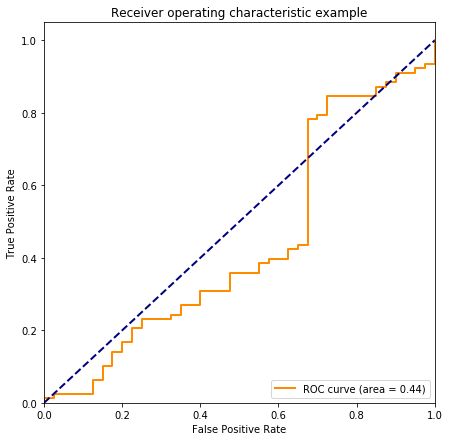

In [274]:
plot_roc_curve(test_ds_raw.Diagnosis,test_preds)